## Importarea datelor, impreuna cu denumirea coloanelor si tranformarea datelor in tip numeric/ datetime pentru procesare

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('graf2.csv',
                   header=None,
                   names=['luna_an', 'mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun'])
data = data.iloc[1:].reset_index(drop=True) # primul rand contine de fapt numele coloanelor, din cauza modului in care a foist exportat fisierul csv

cols = ['mon', 'tue', 'wed', 'thu', 'fri', 'sat', 'sun']
for col in cols:
    data[col] = pd.to_numeric(data[col])
data['luna_an'] = pd.to_datetime(data['luna_an']) 
data['luna_an'] = data['luna_an'].dt.to_period('M') # datetime devine de tip period cu formatul YYYY-MM

print(data.head(), "luna_an", data['luna_an'].dtype, sep="\n")
data.set_index('luna_an', inplace=True)
print(data.dtypes)

   luna_an     mon     tue     wed     thu     fri     sat     sun
0  2020-01  712.48  587.33  554.92  634.94  769.93  862.36  831.46
1  2020-02  700.00  568.87  543.76  630.94  749.81  855.03  818.47
2  2020-03  664.94  544.91  524.93  593.73  725.00  812.39  794.94
3  2020-04  643.80  512.52  495.06  570.04  712.58  787.56  737.58
4  2020-05  618.73  493.89  468.71  556.22  655.22  745.22  705.19
luna_an
period[M]
mon    float64
tue    float64
wed    float64
thu    float64
fri    float64
sat    float64
sun    float64
dtype: object


In [27]:
print(data)

            mon     tue     wed     thu     fri     sat     sun
luna_an                                                        
2020-01  712.48  587.33  554.92  634.94  769.93  862.36  831.46
2020-02  700.00  568.87  543.76  630.94  749.81  855.03  818.47
2020-03  664.94  544.91  524.93  593.73  725.00  812.39  794.94
2020-04  643.80  512.52  495.06  570.04  712.58  787.56  737.58
2020-05  618.73  493.89  468.71  556.22  655.22  745.22  705.19
2020-06  585.05  480.06  456.23  525.00  637.60  737.88  681.22
2020-07  575.00  481.06  444.85  525.22  634.90  712.44  693.66
2020-08  614.44  487.28  468.61  537.32  656.23  744.92  709.51
2020-09  637.48  519.95  489.90  581.20  700.00  774.78  756.28
2020-10  656.33  556.33  518.74  605.06  730.18  815.10  787.53
2020-11  700.03  556.40  525.00  625.00  775.33  869.05  830.00
2020-12  706.14  580.27  560.06  639.94  781.23  856.57  824.87
2021-01  699.85  581.39  537.62  625.24  780.26  884.90  844.62
2021-02  693.63  556.35  550.00  631.14 

De mentionat ca `train2.csv` a fost obtinut dupa executarea unei interogari, prin click dreapta pe tabela, optiunea export, tipul fisierului ales `csv` si calea de salvare a fisierului impreuna cu denumirea lui

## Plotarea trend-ului de vanzari din fiecare luna in functie de ziua din saptamana

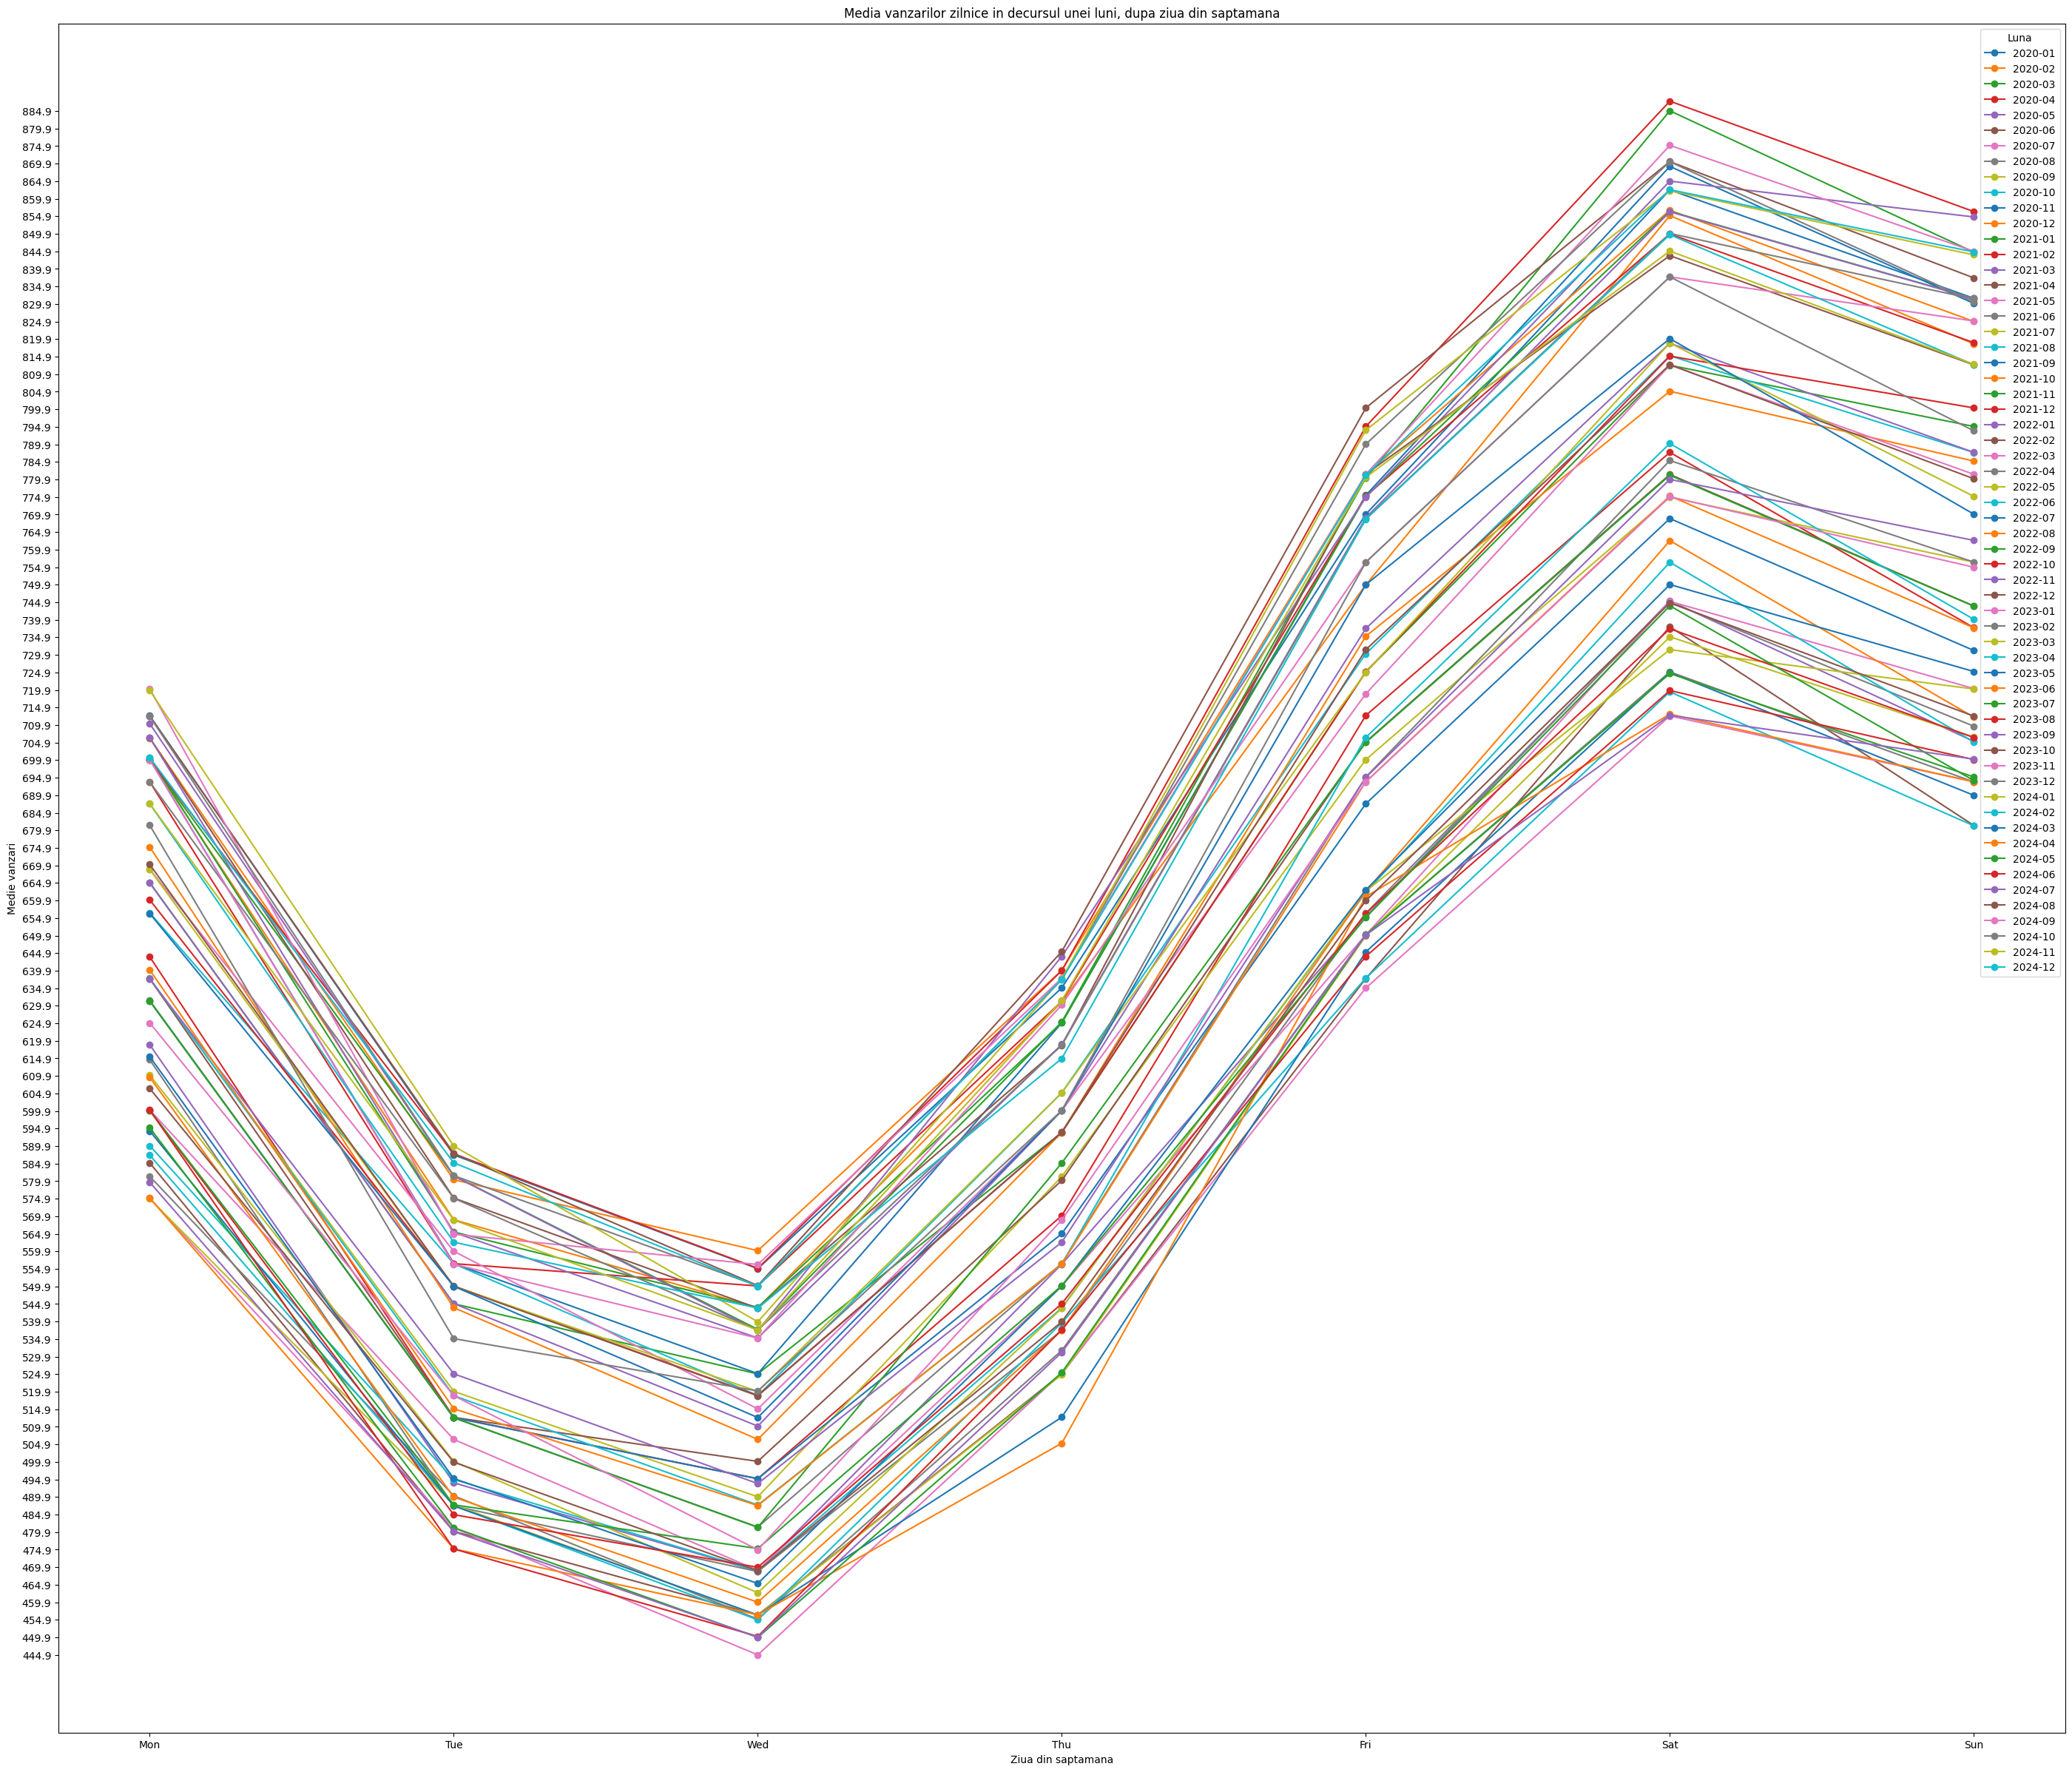

In [28]:
data.T.plot(marker='o', figsize=(35, 30))

plt.title("Media vanzarilor zilnice in decursul unei luni, dupa ziua din saptamana")
plt.xlabel("Ziua din saptamana")
plt.ylabel("Medie vanzari")

plt.yticks(np.arange(data[cols].min().min(), data[cols].max().max()+1, step=5))
plt.xticks(ticks=range(7), labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])

plt.legend(title='Luna', bbox_to_anchor=(1, 1))
plt.show()

Se poate observa mai jos cum graful vanzarilor respecta un ciclu saptamanal care se bazeaza pe formula:

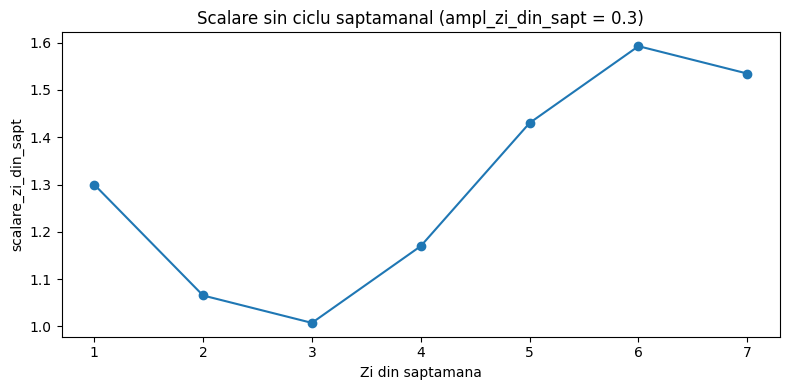

In [29]:
ampl_zi_din_sapt = 0.3
x = np.arange(1, 8)

scalare_zi_din_sapt = 1.0 + ampl_zi_din_sapt * (1-np.sin(2*np.pi*(x-1)/7))

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x, scalare_zi_din_sapt, marker='o')
#plt.xticks(ticks=range(8), labels=['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax.set_xlabel('Zi din saptamana')
ax.set_ylabel('scalare_zi_din_sapt')
ax.set_title('Scalare sin ciclu saptamanal (ampl_zi_din_sapt = 0.3)')
plt.tight_layout()
plt.show()

## Preprocesare date, selectie features, antrenare model XGBoost

In [30]:
data1 = pd.read_csv('graf1.csv',# inserari de date impreuna cu suma de cnatitate a produselor adugate la comenzi in ziua respeciva
                   header=None,
                   names=['data_achizitie', 'cantitate'])
data1 = data1[1:]

data1['cantitate'] = pd.to_numeric(data1['cantitate'])
data1['data_achizitie'] = pd.to_datetime(data1['data_achizitie'])

print(data1.dtypes)
data1.set_index('data_achizitie', inplace=True)
print(data1.head())

data_achizitie    datetime64[ns]
cantitate                  int64
dtype: object
                cantitate
data_achizitie           
2020-01-01            550
2020-01-02            650
2020-01-03            750
2020-01-04            900
2020-01-05            800


C:\Users\Admin\AppData\Local\Temp\ipykernel_5532\3382898383.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data1['data_achizitie'] = pd.to_datetime(data1['data_achizitie'])


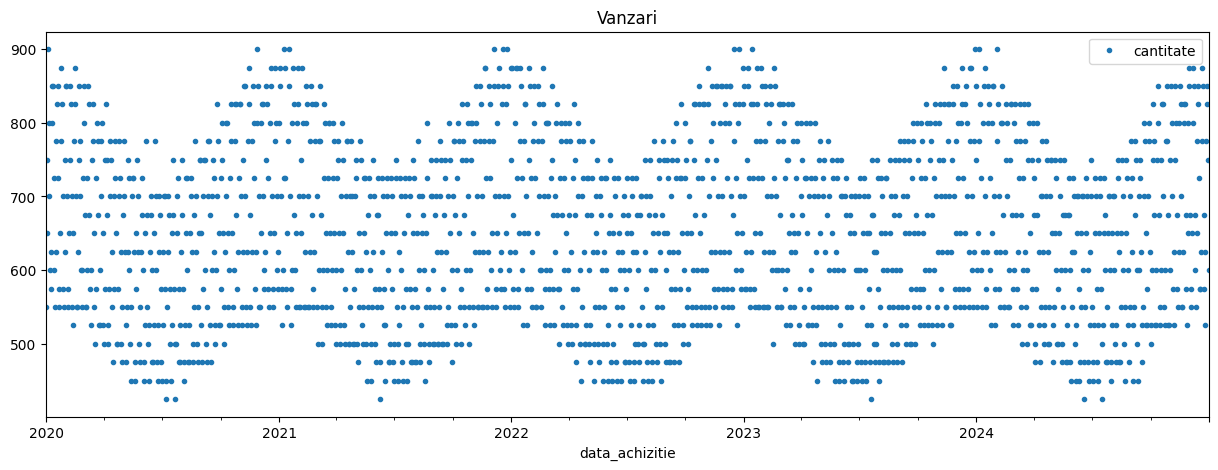

In [31]:
data1.plot(style=".",
    figsize=(15, 5), title='Vanzari')
plt.show()

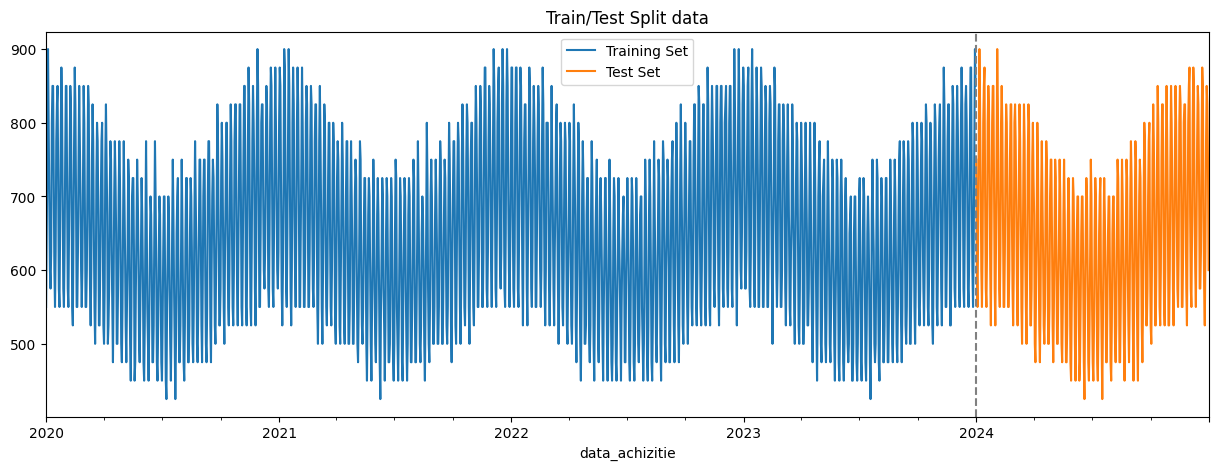

In [32]:
train = data1.loc[data1.index < '01-01-2024']
test = data1.loc[data1.index >= '01-01-2024']

fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Train', title='Train/Test Split data')
test.plot(ax=ax, label='Test')
ax.axvline('01-01-2024', color='Gray', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [33]:
def create_features(df):
    df = df.copy()
    df['zi_din_sapt'] = df.index.dayofweek
    df['anotimp'] = df.index.quarter
    df['luna'] = df.index.month
    df['an'] = df.index.year
    return df

train = create_features(train)
test = create_features(test)

FEATURES = ['zi_din_sapt', 'anotimp', 'luna', 'an']
TARGET = 'cantitate'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [34]:
import xgboost as xgb
from sklearn.metrics import r2_score

reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                       n_estimators=1000,
                       early_stopping_rounds=50,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)


[0]	validation_0-rmse:653.26415	validation_1-rmse:652.10113
[100]	validation_0-rmse:243.51986	validation_1-rmse:242.53845
[200]	validation_0-rmse:94.42397	validation_1-rmse:93.48050
[300]	validation_0-rmse:41.91901	validation_1-rmse:40.99223
[400]	validation_0-rmse:25.57141	validation_1-rmse:24.74487


c:\Users\Admin\Documents\IKEA_OversiktData_PLSQL\esm_forecast_env\Lib\site-packages\xgboost\callback.py:386: UserWarning: [13:39:25] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:250: reg:linear is now deprecated in favor of reg:squarederror.
  self.starting_round = model.num_boosted_rounds()


[500]	validation_0-rmse:21.13628	validation_1-rmse:20.46608
[600]	validation_0-rmse:19.86287	validation_1-rmse:19.33289
[700]	validation_0-rmse:19.40495	validation_1-rmse:18.96532
[800]	validation_0-rmse:19.19931	validation_1-rmse:18.83492
[900]	validation_0-rmse:19.09591	validation_1-rmse:18.77812
[999]	validation_0-rmse:19.03729	validation_1-rmse:18.75701


,objective,'reg:linear'
,base_score,0.5
,booster,'gbtree'
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,50
,enable_categorical,False
,eval_metric,None


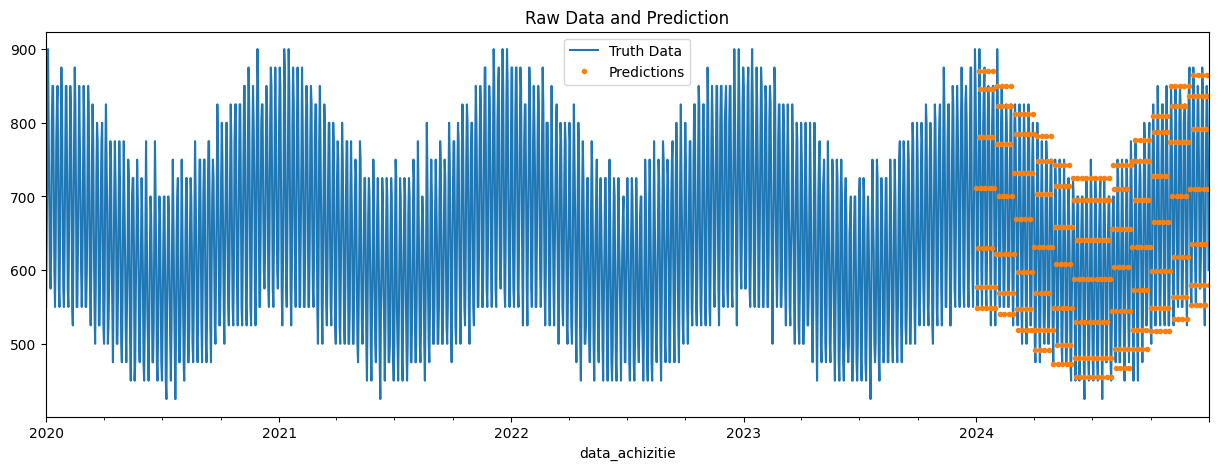

In [35]:
test['prediction_xg'] = reg.predict(X_test)
data1 = data1.merge(test[['prediction_xg']], how='left', left_index=True, right_index=True)
ax = data1[['cantitate']].plot(figsize=(15, 5))
data1['prediction_xg'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

In [36]:
xg_r2 = r2_score(test['cantitate'], test['prediction_xg'])
print('R2 Score: ', xg_r2)

R2 Score:  0.9745228886604309


C:\Users\Admin\AppData\Local\Temp\ipykernel_5532\2843166372.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv('xgboost_pred_output.csv', parse_dates=['CASE_ID']).set_index('CASE_ID')


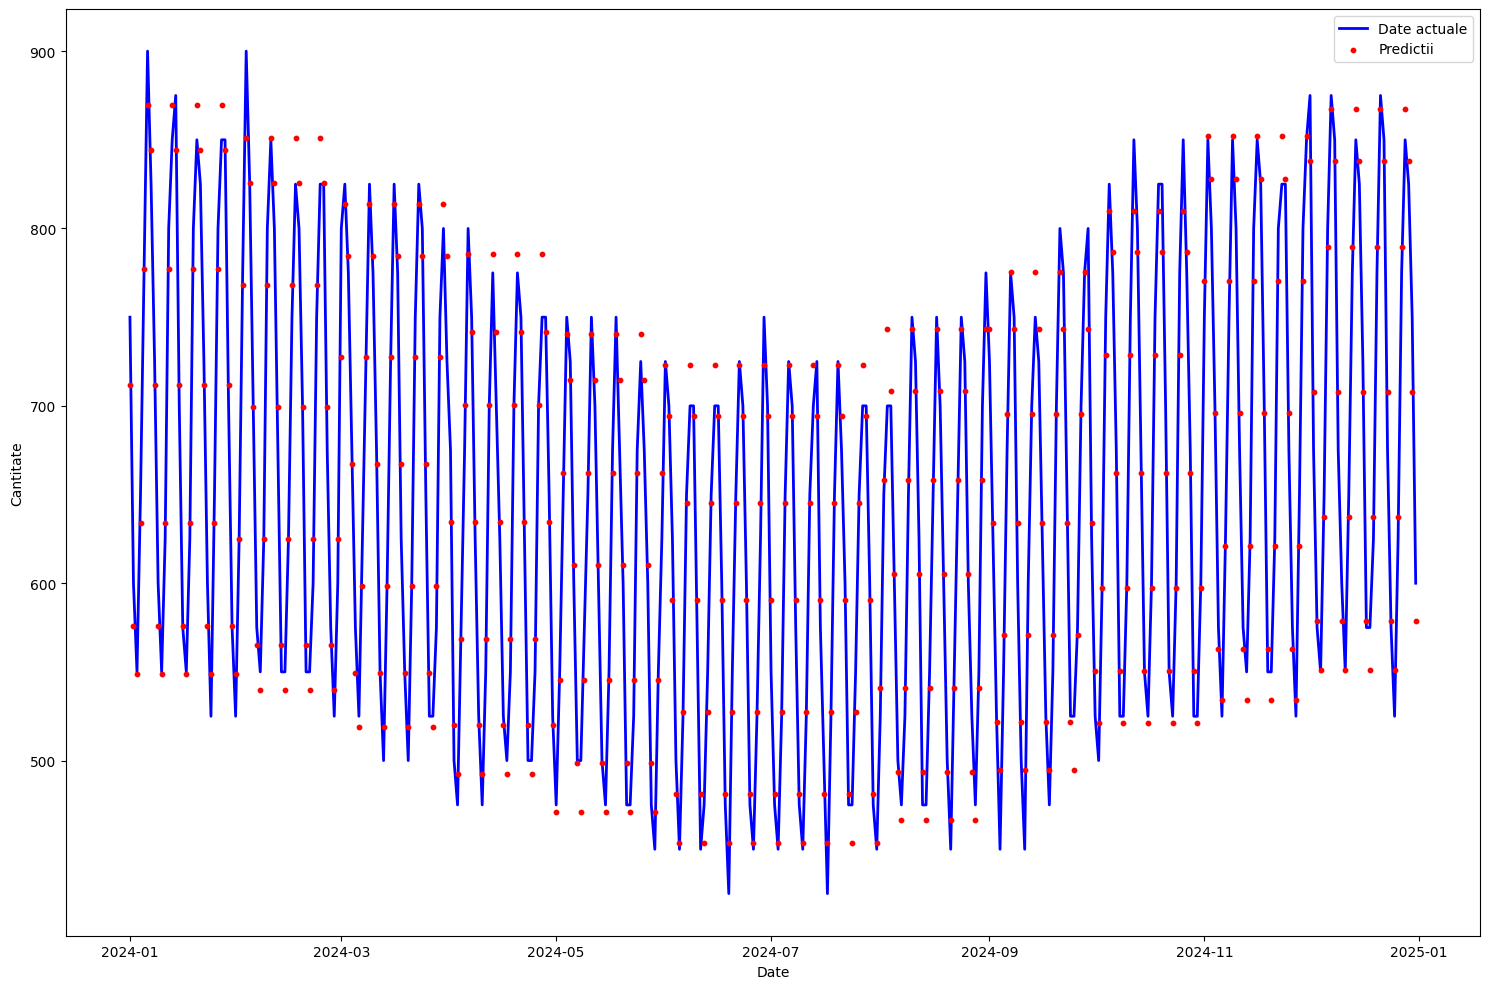

In [37]:
df = pd.read_csv('xgboost_pred_output.csv', parse_dates=['CASE_ID']).set_index('CASE_ID')

fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(df.index, df['ACTUAL'], color='blue', linewidth=2, label='Date actuale')
ax.scatter(df.index, df['PREDICTION'], color='red', s=10, label='Predictii', zorder=3)
ax.set_xlabel('Date')
ax.set_ylabel('Cantitate')
ax.legend()
plt.tight_layout()
plt.show()